In [1]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import \
    get_base_prior_parameters, get_base_sufficient_parameters, get_base_moment_parameters, \
    set_moments, get_e_log_prior, e_data_log_lik, get_e_random_effect_log_lik, \
    get_entropy, get_elbo_model_term, get_elbo, \
    LMMDataCache, CoordinateAscentUpdater, KLWrapper, MomentWrapper

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

# Simulate data
N = 10     # observations per group
K = 10      # dimension of regressors
NG = 3000      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 0.0
true_mu_info = 40.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

prior_par = get_base_prior_parameters(K)

print N * NG

30000


In [3]:
lmm_par = get_base_sufficient_parameters(K, NG)
free_par_vec = lmm_par.get_free()

In [4]:
# Define moment parameters
moment_par = get_base_moment_parameters(K, NG)
set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [5]:
get_e_log_prior(moment_par, prior_par)
get_e_random_effect_log_lik(moment_par)
data_cache = LMMDataCache(x_mat, y_vec, y_g_vec)
e_data_log_lik(data_cache, moment_par)
get_elbo_model_term(data_cache, moment_par, prior_par)

-157832.28031101893

In [6]:
# Perform coordinate ascent.

ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
while delta > tol:
    delta = ca_updater.update()
    print delta
ca_time = time.time() - ca_time

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in minutes):'
print ca_time / 60.

3309.64220869
465.340372493
219.455836823
123.790058714
79.1335770999
55.4062215829
41.2787047487
32.1256634044
25.8165636739
21.2596836197
17.8463769009
15.2141361317
13.1353560361
11.4608490363
10.0892679187
8.94965442545
7.99102680993
7.17592754366
6.47629231659
5.87072887015
5.34267908288
4.87914977865
4.46981871776
4.10639347462
3.78214448433
3.49155964094
3.23008554158
2.99393123215
2.77991768068
2.58536112456
2.40798180027
2.24583189627
2.09723820862
1.96075614599
1.83513257118
1.71927557796
1.61222975252
1.513155803
1.4213136912
1.33604858989
1.25677913356
1.18298754105
1.11421127426
1.05003596371
0.990089383962
0.934036303133
0.881574063201
0.83242877401
0.786352024556
0.743118032032
0.702521162632
0.664373769178
0.628504299693
0.59475563835
0.562983646409
0.533055875745
0.504850431731
0.478254965763
0.453165780575
0.429487033963
0.407130028563
0.386012577064
0.366058433698
0.347196784109
0.329361786714
0.312492159618
0.296530807895
0.281424486701
0.267123496262
0.25358140528


In [7]:
print get_elbo_model_term(data_cache, moment_par, prior_par)
print get_entropy(lmm_par)
print get_elbo(data_cache, lmm_par, moment_par, prior_par)

-157832.280311
4274.42392348
-153557.856388


In [8]:
kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, 20)
print kl_wrapper.kl(free_par_vec)

import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.kl(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: kl_wrapper.kl_grad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: kl_wrapper.kl_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num

153557.856388
Function time:
0.00117340087891
Grad time:
0.00943748950958
Hessian vector product time:
0.0205538988113


In [9]:
# Optimize.
vb_time = time.time()

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
153557.856388
87792.0087525
72452.392122
60404.0974511
49855.819994
42473.8910026
32343.6781202
30472.2023224
61459.88218
26013.03971
24677.4380211
24401.3932767
23737.6565741
22758.7274486
22753.3472991
22205.3657073
22048.5916095
21389.7806092
20855.1664809
20843.6466316
19226.0209368
18863.9906737
18859.0472968
17058.8597339
16071.3923093
16048.8125234
16035.4768638
13493.7688489
13320.465157
13224.7825952
13223.6740546
12692.7992928
12688.5454671
12688.1671918
12600.5719903
12600.020955
12599.4266964
12603.1567729
12603.1567729
12603.1567729
12596.0654087
12595.9146348
12595.4220024
12595.419287
12590.0787116
12589.2647102
12589.1609639
12589.1592613
12588.9249201
12582.5771924
12582.502264
12581.6932099
12581.6925971
12580.7548217
12577.6131981
12577.6005771
12577.5823489
12577.4278141
12577.4277405
12577.4275637
12577.4264042
12577.4258175
12577.4258173
12577.4258173
Optimization terminated successfully.
         Current function value: 12577.425817
  

In [10]:
moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))

print 'total moment difference: %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time

total moment difference: 0.000000
trust region seconds: 10.095314
coordinate ascent seconds: 3.623576


--------------- beta:

[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
[-4.51024191 -3.49376622 -2.49277348 -1.49518635 -0.47823049  0.51105396
  1.49509793  2.49143445  3.48815242  4.50446873]
--------------- mu:

-0.00243336383754
0.0
--------------- mu info:

38.430166522
40.0
--------------- y info:

1.00306460041
1.0


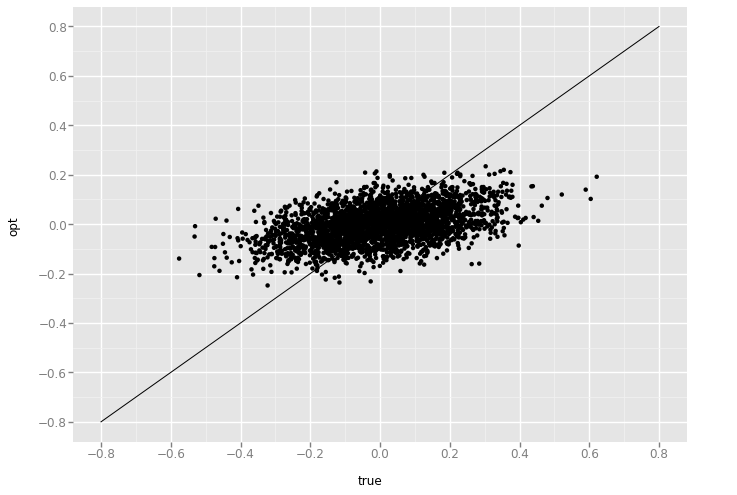

<ggplot: (8789977322521)>


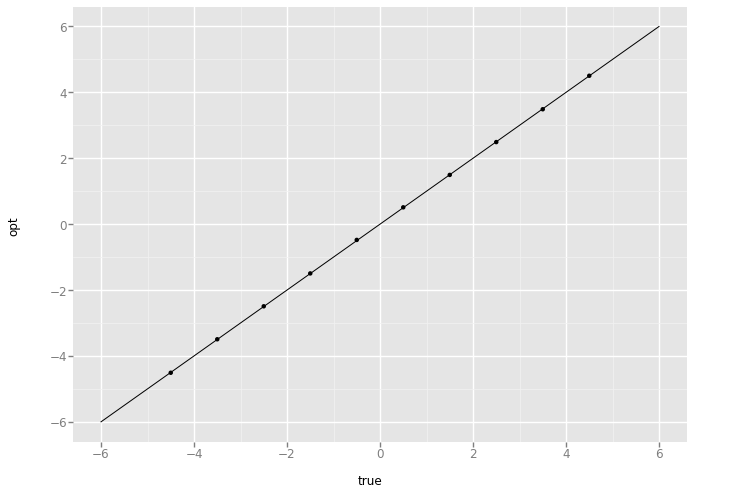

<ggplot: (8789977219441)>


In [11]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

e_u = lmm_par_opt['u'].e()

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [12]:
# Slow, but probably faster than using CG if you want the covariance of many parameters.
hess_time = time.time()
print 'Calculating KL Hessian...'
kl_hess = kl_wrapper.kl_hess(vb_opt.x)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess
print 'Done.'

print 'Hessian time (seconds): %f' % hess_time

Calculating KL Hessian...
Done.
Hessian time (seconds): 53.384805


In [13]:
hess_norm = np.sqrt(np.sum(kl_hess**2))
diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# How diagonal is the Hessian?
print 'Proportion of the frobenius norm off the diagonal:'
print (hess_norm - diag_norm) / hess_norm

Proportion of the frobenius norm off the diagonal:
0.0163666995318
